<a href="https://colab.research.google.com/github/LuellaS/testRepo/blob/main/Praca_domowa_08_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.



In [ ]:

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# install optuna
! pip install optuna

In [ ]:
import optuna


**1-dimensional data**

In [ ]:
def funct(x):
  return (x**3+2**x*2+10+np.cos(x)+np.log(x**3))
size = 90
low=0
high=15
error=15

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(90,) (90,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

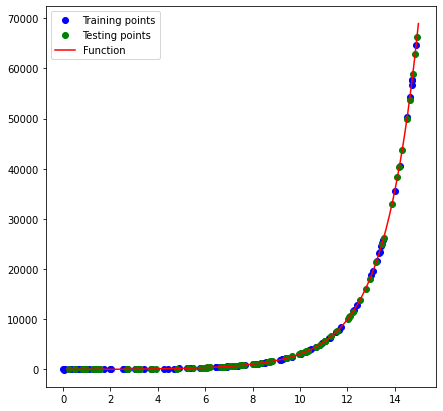

In [ ]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show


**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [ ]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe

# 
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

Define neural network

In [ ]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers



In [ ]:

def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [ ]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=300)

study.best_params 


[I 2020-12-08 11:49:45,773] A new study created in memory with name: no-name-dc3d664b-84e1-4236-95d8-566962869f68
[I 2020-12-08 11:49:45,784] A new study created in memory with name: no-name-6482055b-706e-48d8-8ad7-028fb27d4b43


3/3 [==============================] - 0s 4ms/step - loss: 0.1781 - mse: 0.1781


[I 2020-12-08 11:49:57,345] Trial 0 finished with value: 0.17813687026500702 and parameters: {'units': 1278.0, 'dropout': 0.41503926940092567, 'lr': 0.0009577062973770334, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.17813687026500702.


3/3 [==============================] - 0s 3ms/step - loss: 0.0423 - mse: 0.0423


[I 2020-12-08 11:50:08,478] Trial 1 finished with value: 0.04229392111301422 and parameters: {'units': 35.0, 'dropout': 0.4863189751403396, 'lr': 0.0010286104502583407, 'activation': 'relu'}. Best is trial 1 with value: 0.04229392111301422.


Epoch 00339: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0183 - mse: 0.0183


[I 2020-12-08 11:50:16,423] Trial 2 finished with value: 0.018329357728362083 and parameters: {'units': 998.0, 'dropout': 0.23208711109742913, 'lr': 0.0005379890290721816, 'activation': 'relu'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00239: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.6472 - mse: 0.6472


[I 2020-12-08 11:50:22,361] Trial 3 finished with value: 0.6471937894821167 and parameters: {'units': 1396.0, 'dropout': 0.019634617902543394, 'lr': 0.0015242922745239398, 'activation': 'sigmoid'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00325: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0241 - mse: 0.0241


[I 2020-12-08 11:50:30,108] Trial 4 finished with value: 0.0241419468075037 and parameters: {'units': 1312.0, 'dropout': 0.04753880724000942, 'lr': 0.000717161792187572, 'activation': 'relu'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00211: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0311 - mse: 0.0311


[I 2020-12-08 11:50:35,333] Trial 5 finished with value: 0.03110422007739544 and parameters: {'units': 1096.0, 'dropout': 0.023963655075515122, 'lr': 0.0010578446794507106, 'activation': 'relu'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00318: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0438 - mse: 0.0438


[I 2020-12-08 11:50:42,953] Trial 6 finished with value: 0.043790675699710846 and parameters: {'units': 1110.0, 'dropout': 0.06904712067901236, 'lr': 0.0017662747673472653, 'activation': 'relu'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00108: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5248 - mse: 0.5248


[I 2020-12-08 11:50:46,029] Trial 7 finished with value: 0.5247581005096436 and parameters: {'units': 13.0, 'dropout': 0.2809528616897444, 'lr': 0.0007582598033153163, 'activation': 'linear'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00058: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5204 - mse: 0.5204


[I 2020-12-08 11:50:48,524] Trial 8 finished with value: 0.5203971266746521 and parameters: {'units': 287.0, 'dropout': 0.4382401355451012, 'lr': 0.0009990661096966732, 'activation': 'linear'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00254: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5593 - mse: 0.5593


[I 2020-12-08 11:50:54,896] Trial 9 finished with value: 0.5593305826187134 and parameters: {'units': 1408.0, 'dropout': 0.061866416740450014, 'lr': 0.0009550498008925002, 'activation': 'sigmoid'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00266: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0228 - mse: 0.0228


[I 2020-12-08 11:51:01,660] Trial 10 finished with value: 0.022769251838326454 and parameters: {'units': 1860.0, 'dropout': 0.2046604877746575, 'lr': 0.0005229709538369457, 'activation': 'relu'}. Best is trial 2 with value: 0.018329357728362083.


Epoch 00320: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0162 - mse: 0.0162


[I 2020-12-08 11:51:09,636] Trial 11 finished with value: 0.016216399148106575 and parameters: {'units': 2045.0, 'dropout': 0.2012039923295339, 'lr': 0.000514492865178698, 'activation': 'relu'}. Best is trial 11 with value: 0.016216399148106575.


3/3 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091


[I 2020-12-08 11:51:20,858] Trial 12 finished with value: 0.009066985920071602 and parameters: {'units': 653.0, 'dropout': 0.2094798869003259, 'lr': 0.0005507311255302076, 'activation': 'relu'}. Best is trial 12 with value: 0.009066985920071602.


Epoch 00329: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042


[I 2020-12-08 11:51:28,469] Trial 13 finished with value: 0.004190147388726473 and parameters: {'units': 631.0, 'dropout': 0.158645596829098, 'lr': 0.0006213641816621745, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00370: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0182 - mse: 0.0182


[I 2020-12-08 11:51:36,951] Trial 14 finished with value: 0.018155023455619812 and parameters: {'units': 579.0, 'dropout': 0.13712411712102743, 'lr': 0.0006509380823279253, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00060: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5552 - mse: 0.5552


[I 2020-12-08 11:51:39,002] Trial 15 finished with value: 0.5552337765693665 and parameters: {'units': 681.0, 'dropout': 0.32010689126597464, 'lr': 0.00061951460500015, 'activation': 'linear'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00225: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0156 - mse: 0.0156


[I 2020-12-08 11:51:44,512] Trial 16 finished with value: 0.015638215467333794 and parameters: {'units': 652.0, 'dropout': 0.12895571244981005, 'lr': 0.000804567625996605, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00318: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0082 - mse: 0.0082


[I 2020-12-08 11:51:51,870] Trial 17 finished with value: 0.008203190751373768 and parameters: {'units': 362.0, 'dropout': 0.3498412005629741, 'lr': 0.0012824323080244597, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00307: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0210 - mse: 0.0210


[I 2020-12-08 11:51:58,880] Trial 18 finished with value: 0.020996497943997383 and parameters: {'units': 307.0, 'dropout': 0.339254985321673, 'lr': 0.0013970103768689754, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0895 - mse: 0.0895


[I 2020-12-08 11:52:10,048] Trial 19 finished with value: 0.08945994079113007 and parameters: {'units': 455.0, 'dropout': 0.3767468830115794, 'lr': 0.001257082695513958, 'activation': 'sigmoid'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00066: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5215 - mse: 0.5215


[I 2020-12-08 11:52:12,379] Trial 20 finished with value: 0.5215291380882263 and parameters: {'units': 850.0, 'dropout': 0.13974260870399796, 'lr': 0.0012142515725983274, 'activation': 'linear'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0097 - mse: 0.0097


[I 2020-12-08 11:52:23,896] Trial 21 finished with value: 0.009688417427241802 and parameters: {'units': 264.0, 'dropout': 0.27104145148016595, 'lr': 0.0006075127362682096, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00120: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0329 - mse: 0.0329


[I 2020-12-08 11:52:27,161] Trial 22 finished with value: 0.032853011041879654 and parameters: {'units': 825.0, 'dropout': 0.18200866791086848, 'lr': 0.0019033675589638054, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00460: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099


[I 2020-12-08 11:52:38,026] Trial 23 finished with value: 0.009914013557136059 and parameters: {'units': 459.0, 'dropout': 0.3198721109358208, 'lr': 0.0008341917174376287, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00323: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083


[I 2020-12-08 11:52:45,628] Trial 24 finished with value: 0.008251850493252277 and parameters: {'units': 172.0, 'dropout': 0.10137653730967197, 'lr': 0.0015219155758816635, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00397: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0071 - mse: 0.0071


[I 2020-12-08 11:52:54,620] Trial 25 finished with value: 0.007056186441332102 and parameters: {'units': 145.0, 'dropout': 0.16292314696742907, 'lr': 0.0016841520133266542, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078


[I 2020-12-08 11:53:05,654] Trial 26 finished with value: 0.0077876257710158825 and parameters: {'units': 105.0, 'dropout': 0.1560051930369985, 'lr': 0.0017183836969605368, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00345: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076    


[I 2020-12-08 11:53:13,628] Trial 27 finished with value: 0.007566614076495171 and parameters: {'units': 117.0, 'dropout': 0.1629743620050744, 'lr': 0.0017735881752783999, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0360 - mse: 0.0360


[I 2020-12-08 11:53:24,743] Trial 28 finished with value: 0.03595578297972679 and parameters: {'units': 10.0, 'dropout': 0.09804842121788207, 'lr': 0.0019951288088367923, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0374 - mse: 0.0374


[I 2020-12-08 11:53:36,300] Trial 29 finished with value: 0.037354785948991776 and parameters: {'units': 180.0, 'dropout': 0.17367167879959114, 'lr': 0.0016983000485929847, 'activation': 'sigmoid'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00226: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 0.0068


[I 2020-12-08 11:53:41,850] Trial 30 finished with value: 0.006784999277442694 and parameters: {'units': 466.0, 'dropout': 0.2421896132228511, 'lr': 0.0015064687843958195, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00126: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0259 - mse: 0.0259


[I 2020-12-08 11:53:45,317] Trial 31 finished with value: 0.02590370364487171 and parameters: {'units': 422.0, 'dropout': 0.24867900953025723, 'lr': 0.0015478717887150867, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00171: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0236 - mse: 0.0236


[I 2020-12-08 11:53:49,704] Trial 32 finished with value: 0.02357908897101879 and parameters: {'units': 821.0, 'dropout': 0.10965471477904021, 'lr': 0.001803557168212793, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00197: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0133 - mse: 0.0133


[I 2020-12-08 11:53:54,654] Trial 33 finished with value: 0.013297338038682938 and parameters: {'units': 504.0, 'dropout': 0.22366538925565627, 'lr': 0.001608875801595831, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099


[I 2020-12-08 11:54:05,890] Trial 34 finished with value: 0.009853877127170563 and parameters: {'units': 133.0, 'dropout': 0.2731605209351096, 'lr': 0.0014002335574772459, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00314: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0085 - mse: 0.0085


[I 2020-12-08 11:54:13,217] Trial 35 finished with value: 0.00851494912058115 and parameters: {'units': 251.0, 'dropout': 0.16099888597580067, 'lr': 0.0011097495719951667, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.0201


[I 2020-12-08 11:54:24,365] Trial 36 finished with value: 0.020073283463716507 and parameters: {'units': 19.0, 'dropout': 0.24165301811891385, 'lr': 0.0019516389708082098, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00170: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0154 - mse: 0.0154


[I 2020-12-08 11:54:28,656] Trial 37 finished with value: 0.015363612212240696 and parameters: {'units': 536.0, 'dropout': 0.08569364964469128, 'lr': 0.0014448436053201182, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.1444 - mse: 0.1444


[I 2020-12-08 11:54:39,725] Trial 38 finished with value: 0.14440730214118958 and parameters: {'units': 996.0, 'dropout': 0.1847872928818431, 'lr': 0.0008964147485998622, 'activation': 'sigmoid'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00326: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050


[I 2020-12-08 11:54:47,884] Trial 39 finished with value: 0.005048103630542755 and parameters: {'units': 366.0, 'dropout': 0.2981309089114922, 'lr': 0.001830707874825943, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00060: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.7392 - mse: 0.7392


[I 2020-12-08 11:54:49,976] Trial 40 finished with value: 0.7391761541366577 and parameters: {'units': 785.0, 'dropout': 0.29796757661131645, 'lr': 0.0011201055576938277, 'activation': 'linear'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00262: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0485 - mse: 0.0485


[I 2020-12-08 11:54:56,252] Trial 41 finished with value: 0.04853205010294914 and parameters: {'units': 374.0, 'dropout': 0.22324421701398922, 'lr': 0.0018363578692623494, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00468: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070


[I 2020-12-08 11:55:06,734] Trial 42 finished with value: 0.006985209882259369 and parameters: {'units': 94.0, 'dropout': 0.2598985977375553, 'lr': 0.0016409720136572369, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00361: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0705 - mse: 0.0705


[I 2020-12-08 11:55:15,028] Trial 43 finished with value: 0.07048191130161285 and parameters: {'units': 226.0, 'dropout': 0.29195659761939385, 'lr': 0.0016449501928219145, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00379: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0085 - mse: 0.0085


[I 2020-12-08 11:55:23,692] Trial 44 finished with value: 0.008549312129616737 and parameters: {'units': 368.0, 'dropout': 0.3999064780289442, 'lr': 0.0013279088775468909, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00143: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0208 - mse: 0.0208


[I 2020-12-08 11:55:27,473] Trial 45 finished with value: 0.020797163248062134 and parameters: {'units': 615.0, 'dropout': 0.26113773812893315, 'lr': 0.001490915106280746, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00298: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0426 - mse: 0.0426


[I 2020-12-08 11:55:34,418] Trial 46 finished with value: 0.04260677844285965 and parameters: {'units': 322.0, 'dropout': 0.2372549398223179, 'lr': 0.0019892479970801047, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00477: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0173 - mse: 0.0173


[I 2020-12-08 11:55:45,174] Trial 47 finished with value: 0.01728985086083412 and parameters: {'units': 82.0, 'dropout': 0.3146501616653413, 'lr': 0.0015895611078539326, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00202: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0904 - mse: 0.0904


[I 2020-12-08 11:55:50,187] Trial 48 finished with value: 0.09038960188627243 and parameters: {'units': 706.0, 'dropout': 0.1998280043454212, 'lr': 0.0018718407335905512, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00055: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5280 - mse: 0.5280


[I 2020-12-08 11:55:52,130] Trial 49 finished with value: 0.528041660785675 and parameters: {'units': 977.0, 'dropout': 0.008174951709690348, 'lr': 0.0007020173162726521, 'activation': 'linear'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00328: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.1897 - mse: 0.1897


[I 2020-12-08 11:55:59,949] Trial 50 finished with value: 0.18972919881343842 and parameters: {'units': 1152.0, 'dropout': 0.49575415728804656, 'lr': 0.001688856856396028, 'activation': 'sigmoid'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00367: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0066 - mse: 0.0066


[I 2020-12-08 11:56:08,333] Trial 51 finished with value: 0.006569568999111652 and parameters: {'units': 75.0, 'dropout': 0.03656840786214724, 'lr': 0.0018159888798534205, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00372: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0283 - mse: 0.0283


[I 2020-12-08 11:56:16,826] Trial 52 finished with value: 0.028347566723823547 and parameters: {'units': 35.0, 'dropout': 0.3529738938948309, 'lr': 0.0017838171165467406, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00368: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 0.0100


[I 2020-12-08 11:56:25,118] Trial 53 finished with value: 0.010010670870542526 and parameters: {'units': 222.0, 'dropout': 0.06142750693416374, 'lr': 0.0015973589718392227, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00238: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0307 - mse: 0.0307


[I 2020-12-08 11:56:31,525] Trial 54 finished with value: 0.030741460621356964 and parameters: {'units': 1512.0, 'dropout': 0.029503396404540277, 'lr': 0.0013577042638769031, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00219: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0223 - mse: 0.0223


[I 2020-12-08 11:56:36,947] Trial 55 finished with value: 0.022280976176261902 and parameters: {'units': 539.0, 'dropout': 0.29768680156370864, 'lr': 0.0014618417648817803, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00385: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0411 - mse: 0.0411


[I 2020-12-08 11:56:45,802] Trial 56 finished with value: 0.04114518314599991 and parameters: {'units': 317.0, 'dropout': 0.4665869250451745, 'lr': 0.001869650312858531, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


Epoch 00230: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0455 - mse: 0.0455


[I 2020-12-08 11:56:51,456] Trial 57 finished with value: 0.04550456628203392 and parameters: {'units': 429.0, 'dropout': 0.2620212324514994, 'lr': 0.0016788076147986218, 'activation': 'relu'}. Best is trial 13 with value: 0.004190147388726473.


3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038


[I 2020-12-08 11:57:02,788] Trial 58 finished with value: 0.0038289357908070087 and parameters: {'units': 177.0, 'dropout': 0.12094985941342817, 'lr': 0.0005706148532170895, 'activation': 'relu'}. Best is trial 58 with value: 0.0038289357908070087.


Epoch 00302: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0097 - mse: 0.0097


[I 2020-12-08 11:57:09,900] Trial 59 finished with value: 0.009686533361673355 and parameters: {'units': 758.0, 'dropout': 0.12460480788910036, 'lr': 0.0005932462181809284, 'activation': 'relu'}. Best is trial 58 with value: 0.0038289357908070087.


3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052


[I 2020-12-08 11:57:21,160] Trial 60 finished with value: 0.005190126597881317 and parameters: {'units': 62.0, 'dropout': 0.07384275272456453, 'lr': 0.0005617899585847512, 'activation': 'relu'}. Best is trial 58 with value: 0.0038289357908070087.


3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050


[I 2020-12-08 11:57:33,026] Trial 61 finished with value: 0.005026503931730986 and parameters: {'units': 75.0, 'dropout': 0.044949713524277624, 'lr': 0.000541189893184855, 'activation': 'relu'}. Best is trial 58 with value: 0.0038289357908070087.


Epoch 00407: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046


[I 2020-12-08 11:57:42,276] Trial 62 finished with value: 0.0046300278045237064 and parameters: {'units': 254.0, 'dropout': 0.03829623293900183, 'lr': 0.000561945721882338, 'activation': 'relu'}. Best is trial 58 with value: 0.0038289357908070087.


Epoch 00500: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0088 - mse: 0.0088


[I 2020-12-08 11:57:53,575] Trial 63 finished with value: 0.008755308575928211 and parameters: {'units': 211.0, 'dropout': 0.037767047823939026, 'lr': 0.0005591401007520217, 'activation': 'relu'}. Best is trial 58 with value: 0.0038289357908070087.


3/3 [==============================] - 0s 4ms/step - loss: 0.0165 - mse: 0.0165


[I 2020-12-08 11:58:04,673] Trial 64 finished with value: 0.016549676656723022 and parameters: {'units': 37.0, 'dropout': 0.05174807403209349, 'lr': 0.0005094280508405682, 'activation': 'relu'}. Best is trial 58 with value: 0.0038289357908070087.


3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 11:58:15,886] Trial 65 finished with value: 0.002354624681174755 and parameters: {'units': 185.0, 'dropout': 0.0697522582329849, 'lr': 0.0005699150512740849, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.0134 - mse: 0.0134


[I 2020-12-08 11:58:26,951] Trial 66 finished with value: 0.01335094217211008 and parameters: {'units': 276.0, 'dropout': 0.07776239645384661, 'lr': 0.0005638420834762916, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00070: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5270 - mse: 0.5270


[I 2020-12-08 11:58:29,178] Trial 67 finished with value: 0.5269919633865356 and parameters: {'units': 166.0, 'dropout': 0.0009810727853738072, 'lr': 0.0006406263147939565, 'activation': 'linear'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00288: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 0.0098


[I 2020-12-08 11:58:36,241] Trial 68 finished with value: 0.009777916595339775 and parameters: {'units': 393.0, 'dropout': 0.013313731986905632, 'lr': 0.000537908634912709, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045


[I 2020-12-08 11:58:47,393] Trial 69 finished with value: 0.00450452696532011 and parameters: {'units': 179.0, 'dropout': 0.11760370382383695, 'lr': 0.0005915089210257776, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.5049 - mse: 0.5049


[I 2020-12-08 11:58:58,353] Trial 70 finished with value: 0.5048641562461853 and parameters: {'units': 314.0, 'dropout': 0.10850737666126918, 'lr': 0.0005890144666627159, 'activation': 'sigmoid'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00491: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056


[I 2020-12-08 11:59:09,864] Trial 71 finished with value: 0.005576738156378269 and parameters: {'units': 166.0, 'dropout': 0.09099725631537027, 'lr': 0.0006741924904327178, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.0126 - mse: 0.0126


[I 2020-12-08 11:59:20,965] Trial 72 finished with value: 0.012631861492991447 and parameters: {'units': 244.0, 'dropout': 0.12141286259965438, 'lr': 0.0005000945066433, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0079


[I 2020-12-08 11:59:32,034] Trial 73 finished with value: 0.007901046425104141 and parameters: {'units': 82.0, 'dropout': 0.14394875802467455, 'lr': 0.0005742044117252338, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.0901 - mse: 0.0901


[I 2020-12-08 11:59:43,290] Trial 74 finished with value: 0.09009853005409241 and parameters: {'units': 17.0, 'dropout': 0.05524002331019723, 'lr': 0.0006272204152112317, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.0063 - mse: 0.0063


[I 2020-12-08 11:59:54,593] Trial 75 finished with value: 0.006271455902606249 and parameters: {'units': 147.0, 'dropout': 0.06790490846983557, 'lr': 0.0005324701775632037, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00446: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077


[I 2020-12-08 12:00:04,665] Trial 76 finished with value: 0.007702372036874294 and parameters: {'units': 201.0, 'dropout': 0.0779126172655519, 'lr': 0.0006067198241759371, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00348: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0200 - mse: 0.0200


[I 2020-12-08 12:00:12,618] Trial 77 finished with value: 0.019975293427705765 and parameters: {'units': 483.0, 'dropout': 0.1126442859638016, 'lr': 0.0007472294556858866, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00346: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064


[I 2020-12-08 12:00:20,583] Trial 78 finished with value: 0.006412385031580925 and parameters: {'units': 350.0, 'dropout': 0.04255729360368361, 'lr': 0.0006578749707604502, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00491: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040


[I 2020-12-08 12:00:31,479] Trial 79 finished with value: 0.0040350318886339664 and parameters: {'units': 281.0, 'dropout': 0.022511176879621765, 'lr': 0.0005185557889278997, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00398: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060


[I 2020-12-08 12:00:40,517] Trial 80 finished with value: 0.0060433135367929935 and parameters: {'units': 281.0, 'dropout': 0.018948990148241134, 'lr': 0.0005256354591839529, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027


[I 2020-12-08 12:00:51,607] Trial 81 finished with value: 0.002694999100640416 and parameters: {'units': 136.0, 'dropout': 0.09268890701918835, 'lr': 0.0005489430222028321, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032


[I 2020-12-08 12:01:02,726] Trial 82 finished with value: 0.0032149937469512224 and parameters: {'units': 138.0, 'dropout': 0.09484243689781102, 'lr': 0.0005888658660004135, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 4ms/step - loss: 0.0043 - mse: 0.0043


[I 2020-12-08 12:01:13,767] Trial 83 finished with value: 0.004300373140722513 and parameters: {'units': 118.0, 'dropout': 0.09572158771140092, 'lr': 0.0005001431022905178, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


Epoch 00418: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067


[I 2020-12-08 12:01:23,343] Trial 84 finished with value: 0.006716443225741386 and parameters: {'units': 902.0, 'dropout': 0.14435951379292852, 'lr': 0.0005006174032262191, 'activation': 'relu'}. Best is trial 65 with value: 0.002354624681174755.


3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022    


[I 2020-12-08 12:01:34,362] Trial 85 finished with value: 0.0022399816662073135 and parameters: {'units': 157.0, 'dropout': 0.09211310856578518, 'lr': 0.0005817118853260213, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028


[I 2020-12-08 12:01:45,385] Trial 86 finished with value: 0.0028497171588242054 and parameters: {'units': 148.0, 'dropout': 0.09760068447910325, 'lr': 0.0005846917541923338, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045


[I 2020-12-08 12:01:56,810] Trial 87 finished with value: 0.0045132264494895935 and parameters: {'units': 126.0, 'dropout': 0.10000451576045181, 'lr': 0.0006833721888277375, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046


[I 2020-12-08 12:02:07,930] Trial 88 finished with value: 0.004563906230032444 and parameters: {'units': 114.0, 'dropout': 0.13312641306055964, 'lr': 0.0006148991793178559, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00069: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.5303 - mse: 0.5303


[I 2020-12-08 12:02:10,143] Trial 89 finished with value: 0.530251145362854 and parameters: {'units': 211.0, 'dropout': 0.08488104444161884, 'lr': 0.0005171545803831483, 'activation': 'linear'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00389: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0085 - mse: 0.0085


[I 2020-12-08 12:02:19,019] Trial 90 finished with value: 0.008465602993965149 and parameters: {'units': 419.0, 'dropout': 0.09541597372018096, 'lr': 0.0006366675197508999, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171


[I 2020-12-08 12:02:30,056] Trial 91 finished with value: 0.017121845856308937 and parameters: {'units': 182.0, 'dropout': 0.119336696896043, 'lr': 0.0005858163812508658, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041    


[I 2020-12-08 12:02:42,103] Trial 92 finished with value: 0.00412521418184042 and parameters: {'units': 148.0, 'dropout': 0.10596052177901678, 'lr': 0.0006041897913173395, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 2ms/step - loss: 0.0319 - mse: 0.0319


[I 2020-12-08 12:02:53,312] Trial 93 finished with value: 0.031892772763967514 and parameters: {'units': 31.0, 'dropout': 0.06412251089469113, 'lr': 0.0005439070468718013, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057


[I 2020-12-08 12:03:04,414] Trial 94 finished with value: 0.005737531930208206 and parameters: {'units': 121.0, 'dropout': 0.10751120694036154, 'lr': 0.0006110221635375212, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.1446 - mse: 0.1446


[I 2020-12-08 12:03:15,581] Trial 95 finished with value: 0.1446080505847931 and parameters: {'units': 9.0, 'dropout': 0.09011820857800436, 'lr': 0.0005771713296335177, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 5ms/step - loss: 0.4247 - mse: 0.4247


[I 2020-12-08 12:03:26,915] Trial 96 finished with value: 0.4247303307056427 and parameters: {'units': 297.0, 'dropout': 0.1534607644722405, 'lr': 0.0006665845182989769, 'activation': 'sigmoid'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027


[I 2020-12-08 12:03:38,151] Trial 97 finished with value: 0.0027265860699117184 and parameters: {'units': 243.0, 'dropout': 0.13209581816342142, 'lr': 0.0005213719412806814, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00495: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030


[I 2020-12-08 12:03:49,668] Trial 98 finished with value: 0.0030331939924508333 and parameters: {'units': 261.0, 'dropout': 0.17944539956654385, 'lr': 0.0007234346043068021, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00439: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0133 - mse: 0.0133


[I 2020-12-08 12:03:59,594] Trial 99 finished with value: 0.013271363452076912 and parameters: {'units': 252.0, 'dropout': 0.1764416199052485, 'lr': 0.0007293019670680066, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076


[I 2020-12-08 12:04:10,680] Trial 100 finished with value: 0.0076118335127830505 and parameters: {'units': 345.0, 'dropout': 0.1329332511904474, 'lr': 0.0008433458914490798, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00464: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052


[I 2020-12-08 12:04:21,042] Trial 101 finished with value: 0.005155227612704039 and parameters: {'units': 214.0, 'dropout': 0.15222142140006958, 'lr': 0.0005523845018240244, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00454: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036


[I 2020-12-08 12:04:31,124] Trial 102 finished with value: 0.0035914352629333735 and parameters: {'units': 277.0, 'dropout': 0.1871204734644608, 'lr': 0.0005209542894703606, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2020-12-08 12:04:41,996] Trial 103 finished with value: 0.0026150792837142944 and parameters: {'units': 293.0, 'dropout': 0.07883581300894536, 'lr': 0.0005229782675407107, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00496: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091


[I 2020-12-08 12:04:52,984] Trial 104 finished with value: 0.00911046378314495 and parameters: {'units': 282.0, 'dropout': 0.057278063104405766, 'lr': 0.000520413571402205, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00454: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030


[I 2020-12-08 12:05:03,786] Trial 105 finished with value: 0.0030357243958860636 and parameters: {'units': 401.0, 'dropout': 0.20923802309620781, 'lr': 0.0005287594137166988, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037    


[I 2020-12-08 12:05:14,859] Trial 106 finished with value: 0.0036880015395581722 and parameters: {'units': 400.0, 'dropout': 0.189796120533524, 'lr': 0.0005731228681722726, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044    


[I 2020-12-08 12:05:26,096] Trial 107 finished with value: 0.004420833196491003 and parameters: {'units': 405.0, 'dropout': 0.1923936248517469, 'lr': 0.0005387347335244151, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077


[I 2020-12-08 12:05:37,292] Trial 108 finished with value: 0.007720216643065214 and parameters: {'units': 585.0, 'dropout': 0.2115267980489017, 'lr': 0.0005488484814952338, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036    


[I 2020-12-08 12:05:48,459] Trial 109 finished with value: 0.0036264127120375633 and parameters: {'units': 344.0, 'dropout': 0.16948611648673056, 'lr': 0.0005095661123333603, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00397: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057


[I 2020-12-08 12:05:57,606] Trial 110 finished with value: 0.005720312241464853 and parameters: {'units': 338.0, 'dropout': 0.17022457847311073, 'lr': 0.0005009543321497291, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041    


[I 2020-12-08 12:06:08,542] Trial 111 finished with value: 0.0041251410730183125 and parameters: {'units': 456.0, 'dropout': 0.2207306866312897, 'lr': 0.0005286485011534791, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 5ms/step - loss: 0.0168 - mse: 0.0168


[I 2020-12-08 12:06:19,602] Trial 112 finished with value: 0.016805797815322876 and parameters: {'units': 245.0, 'dropout': 0.1883988636733662, 'lr': 0.0005764297972622641, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00463: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0148 - mse: 0.0148


[I 2020-12-08 12:06:29,914] Trial 113 finished with value: 0.014849395491182804 and parameters: {'units': 380.0, 'dropout': 0.20066499797386939, 'lr': 0.0005537779465947459, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2020-12-08 12:06:40,942] Trial 114 finished with value: 0.0025805835612118244 and parameters: {'units': 327.0, 'dropout': 0.1651133312574443, 'lr': 0.0005146083628962319, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00292: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0139 - mse: 0.0139


[I 2020-12-08 12:06:48,017] Trial 115 finished with value: 0.013854394666850567 and parameters: {'units': 1592.0, 'dropout': 0.1637196012567396, 'lr': 0.0005132594344642347, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00323: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0073 - mse: 0.0073


[I 2020-12-08 12:06:55,547] Trial 116 finished with value: 0.007320720702409744 and parameters: {'units': 522.0, 'dropout': 0.17270738948980105, 'lr': 0.0005306036786415825, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 12:07:06,680] Trial 117 finished with value: 0.0024357892107218504 and parameters: {'units': 303.0, 'dropout': 0.210232035370145, 'lr': 0.0005030128828014137, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00406: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0122 - mse: 0.0122


[I 2020-12-08 12:07:15,857] Trial 118 finished with value: 0.012235800735652447 and parameters: {'units': 318.0, 'dropout': 0.07823460939558398, 'lr': 0.0005930644060605, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00067: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5245 - mse: 0.5245


[I 2020-12-08 12:07:18,004] Trial 119 finished with value: 0.5245386958122253 and parameters: {'units': 207.0, 'dropout': 0.14446796614561275, 'lr': 0.0005476139322293503, 'activation': 'linear'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0131 - mse: 0.0131


[I 2020-12-08 12:07:28,997] Trial 120 finished with value: 0.013059917837381363 and parameters: {'units': 58.0, 'dropout': 0.23006827253667203, 'lr': 0.0006449178866405476, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056


[I 2020-12-08 12:07:39,876] Trial 121 finished with value: 0.005558898206800222 and parameters: {'units': 246.0, 'dropout': 0.21240323039634101, 'lr': 0.000514076793124406, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00423: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032


[I 2020-12-08 12:07:50,891] Trial 122 finished with value: 0.003242685692384839 and parameters: {'units': 305.0, 'dropout': 0.18079031113895025, 'lr': 0.0005053197047464915, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00495: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061


[I 2020-12-08 12:08:01,992] Trial 123 finished with value: 0.006144021637737751 and parameters: {'units': 298.0, 'dropout': 0.17989173845984002, 'lr': 0.0005007862572545907, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035


[I 2020-12-08 12:08:13,178] Trial 124 finished with value: 0.0035197169054299593 and parameters: {'units': 187.0, 'dropout': 0.20219705728468587, 'lr': 0.0005376271012396101, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00447: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043


[I 2020-12-08 12:08:23,231] Trial 125 finished with value: 0.0043266089633107185 and parameters: {'units': 173.0, 'dropout': 0.20487597562573498, 'lr': 0.0010022002486448488, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0073 - mse: 0.0073


[I 2020-12-08 12:08:34,230] Trial 126 finished with value: 0.007291242014616728 and parameters: {'units': 91.0, 'dropout': 0.21573634334359973, 'lr': 0.0005603323721374026, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055


[I 2020-12-08 12:08:45,669] Trial 127 finished with value: 0.005482410546392202 and parameters: {'units': 141.0, 'dropout': 0.08301676558464736, 'lr': 0.0005397158554208942, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.3871 - mse: 0.3871


[I 2020-12-08 12:08:57,066] Trial 128 finished with value: 0.3870566487312317 and parameters: {'units': 226.0, 'dropout': 0.19749629633080087, 'lr': 0.0006245603729782933, 'activation': 'sigmoid'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00372: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0126 - mse: 0.0126


[I 2020-12-08 12:09:05,548] Trial 129 finished with value: 0.01259635854512453 and parameters: {'units': 192.0, 'dropout': 0.06902382185858677, 'lr': 0.0007738587649917673, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 5ms/step - loss: 0.0116 - mse: 0.0116


[I 2020-12-08 12:09:16,813] Trial 130 finished with value: 0.0116188433021307 and parameters: {'units': 443.0, 'dropout': 0.23206516157993892, 'lr': 0.0005338122612191378, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0126 - mse: 0.0126


[I 2020-12-08 12:09:28,001] Trial 131 finished with value: 0.012577014043927193 and parameters: {'units': 263.0, 'dropout': 0.18517613427617183, 'lr': 0.0005243806358565241, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0156 - mse: 0.0156


[I 2020-12-08 12:09:39,250] Trial 132 finished with value: 0.01563434861600399 and parameters: {'units': 311.0, 'dropout': 0.15759053790279853, 'lr': 0.0005014045287611918, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00411: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0063 - mse: 0.0063


[I 2020-12-08 12:09:48,710] Trial 133 finished with value: 0.0062871999107301235 and parameters: {'units': 366.0, 'dropout': 0.20594936562118962, 'lr': 0.0005617536529882212, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0075 - mse: 0.0075


[I 2020-12-08 12:09:59,914] Trial 134 finished with value: 0.007505886256694794 and parameters: {'units': 155.0, 'dropout': 0.2504601406837871, 'lr': 0.0005970077040071601, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030


[I 2020-12-08 12:10:11,105] Trial 135 finished with value: 0.0029787314124405384 and parameters: {'units': 261.0, 'dropout': 0.12945596192859196, 'lr': 0.0005206499561758603, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0059 - mse: 0.0059


[I 2020-12-08 12:10:22,226] Trial 136 finished with value: 0.0058830431662499905 and parameters: {'units': 223.0, 'dropout': 0.12949863566226935, 'lr': 0.0005741864458299075, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00369: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067


[I 2020-12-08 12:10:30,585] Trial 137 finished with value: 0.006716900505125523 and parameters: {'units': 120.0, 'dropout': 0.14021867737347168, 'lr': 0.0009406871541922258, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045


[I 2020-12-08 12:10:41,579] Trial 138 finished with value: 0.0044956025667488575 and parameters: {'units': 87.0, 'dropout': 0.10408330542865736, 'lr': 0.0005514646081508671, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2020-12-08 12:10:52,660] Trial 139 finished with value: 0.0025547791738063097 and parameters: {'units': 188.0, 'dropout': 0.09110147027869732, 'lr': 0.0005848469496120601, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00222: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319


[I 2020-12-08 12:10:59,110] Trial 140 finished with value: 0.031866785138845444 and parameters: {'units': 2037.0, 'dropout': 0.11748560593254656, 'lr': 0.0005827379361780023, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032


[I 2020-12-08 12:11:10,259] Trial 141 finished with value: 0.003189253155142069 and parameters: {'units': 185.0, 'dropout': 0.09041562082675568, 'lr': 0.0005346188006600393, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052


[I 2020-12-08 12:11:21,377] Trial 142 finished with value: 0.005217764992266893 and parameters: {'units': 238.0, 'dropout': 0.09819168417411622, 'lr': 0.0005073625262727148, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00391: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0102 - mse: 0.0102


[I 2020-12-08 12:11:30,405] Trial 143 finished with value: 0.010224992409348488 and parameters: {'units': 284.0, 'dropout': 0.07052991342993897, 'lr': 0.0006052015593946986, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00462: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0189 - mse: 0.0189


[I 2020-12-08 12:11:40,787] Trial 144 finished with value: 0.018875647336244583 and parameters: {'units': 324.0, 'dropout': 0.09182879904931007, 'lr': 0.0005610083303402131, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 5ms/step - loss: 0.0036 - mse: 0.0036


[I 2020-12-08 12:11:52,071] Trial 145 finished with value: 0.003598021110519767 and parameters: {'units': 165.0, 'dropout': 0.11346402885769809, 'lr': 0.0005283594695202394, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00467: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030


[I 2020-12-08 12:12:02,572] Trial 146 finished with value: 0.0030498181004077196 and parameters: {'units': 211.0, 'dropout': 0.05115376513822793, 'lr': 0.0006234775369239933, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0071 - mse: 0.0071


[I 2020-12-08 12:12:13,795] Trial 147 finished with value: 0.00710728345438838 and parameters: {'units': 47.0, 'dropout': 0.05968316056001188, 'lr': 0.0006322682812828433, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045


[I 2020-12-08 12:12:25,072] Trial 148 finished with value: 0.004505665972828865 and parameters: {'units': 128.0, 'dropout': 0.0849482912316758, 'lr': 0.0006147128388354994, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061


[I 2020-12-08 12:12:36,236] Trial 149 finished with value: 0.0060687377117574215 and parameters: {'units': 206.0, 'dropout': 0.05186753105208934, 'lr': 0.0005823503263339756, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041    


[I 2020-12-08 12:12:47,427] Trial 150 finished with value: 0.004108518362045288 and parameters: {'units': 242.0, 'dropout': 0.07511914789898207, 'lr': 0.0005954308004568652, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091


[I 2020-12-08 12:12:59,246] Trial 151 finished with value: 0.009052674286067486 and parameters: {'units': 367.0, 'dropout': 0.08831950947783133, 'lr': 0.000548789879289056, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00390: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076


[I 2020-12-08 12:13:08,398] Trial 152 finished with value: 0.007600599434226751 and parameters: {'units': 279.0, 'dropout': 0.12803062737348037, 'lr': 0.0006858537581286205, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00497: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042


[I 2020-12-08 12:13:19,629] Trial 153 finished with value: 0.004236129112541676 and parameters: {'units': 188.0, 'dropout': 0.1027324418142387, 'lr': 0.0005683802513417664, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038


[I 2020-12-08 12:13:30,814] Trial 154 finished with value: 0.0038453645538538694 and parameters: {'units': 93.0, 'dropout': 0.06365293418581532, 'lr': 0.0005148984341130259, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00377: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032


[I 2020-12-08 12:13:39,513] Trial 155 finished with value: 0.0031650420278310776 and parameters: {'units': 330.0, 'dropout': 0.08091059938187016, 'lr': 0.0005438227439621885, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0065 - mse: 0.0065


[I 2020-12-08 12:13:50,818] Trial 156 finished with value: 0.006515586283057928 and parameters: {'units': 146.0, 'dropout': 0.07972455574219599, 'lr': 0.0005442541467858112, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00463: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045


[I 2020-12-08 12:14:01,262] Trial 157 finished with value: 0.004491798579692841 and parameters: {'units': 341.0, 'dropout': 0.09622065541848875, 'lr': 0.0005675959929234399, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050


[I 2020-12-08 12:14:12,223] Trial 158 finished with value: 0.004978931974619627 and parameters: {'units': 245.0, 'dropout': 0.030537194042223374, 'lr': 0.000534065604383928, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00396: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099


[I 2020-12-08 12:14:21,882] Trial 159 finished with value: 0.009876575320959091 and parameters: {'units': 408.0, 'dropout': 0.10736815263297746, 'lr': 0.0006516356732118966, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00065: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5301 - mse: 0.5301


[I 2020-12-08 12:14:24,084] Trial 160 finished with value: 0.5300530195236206 and parameters: {'units': 212.0, 'dropout': 0.0701472754484236, 'lr': 0.0005843641532569209, 'activation': 'linear'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033


[I 2020-12-08 12:14:35,188] Trial 161 finished with value: 0.0033468790352344513 and parameters: {'units': 298.0, 'dropout': 0.086629989576163, 'lr': 0.000501209307266447, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0211 - mse: 0.0211


[I 2020-12-08 12:14:46,357] Trial 162 finished with value: 0.02105979062616825 and parameters: {'units': 324.0, 'dropout': 0.04621788164537343, 'lr': 0.000519008996264491, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


Epoch 00461: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0210 - mse: 0.0210


[I 2020-12-08 12:14:56,839] Trial 163 finished with value: 0.020966650918126106 and parameters: {'units': 268.0, 'dropout': 0.1515032900557599, 'lr': 0.0005591164976500016, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029


[I 2020-12-08 12:15:07,951] Trial 164 finished with value: 0.0029389692936092615 and parameters: {'units': 151.0, 'dropout': 0.12263781227007646, 'lr': 0.0005297763984031516, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.1650 - mse: 0.1650


[I 2020-12-08 12:15:19,096] Trial 165 finished with value: 0.16501948237419128 and parameters: {'units': 10.0, 'dropout': 0.11824951511901291, 'lr': 0.0005419601697388697, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033


[I 2020-12-08 12:15:30,320] Trial 166 finished with value: 0.0032637459225952625 and parameters: {'units': 177.0, 'dropout': 0.13472139801794922, 'lr': 0.000526881683037866, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049


[I 2020-12-08 12:15:41,531] Trial 167 finished with value: 0.0049140057526528835 and parameters: {'units': 108.0, 'dropout': 0.109885028960776, 'lr': 0.0006168910761764637, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.4794 - mse: 0.4794


[I 2020-12-08 12:15:52,814] Trial 168 finished with value: 0.4793674945831299 and parameters: {'units': 57.0, 'dropout': 0.1257434042214627, 'lr': 0.0005953871595717491, 'activation': 'sigmoid'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040


[I 2020-12-08 12:16:04,117] Trial 169 finished with value: 0.004001370631158352 and parameters: {'units': 149.0, 'dropout': 0.09702452630351803, 'lr': 0.0005737268893169817, 'activation': 'relu'}. Best is trial 85 with value: 0.0022399816662073135.


3/3 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020


[I 2020-12-08 12:16:15,325] Trial 170 finished with value: 0.001975840888917446 and parameters: {'units': 215.0, 'dropout': 0.0774958236514226, 'lr': 0.0005501633323618153, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00438: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076


[I 2020-12-08 12:16:25,265] Trial 171 finished with value: 0.007640195079147816 and parameters: {'units': 214.0, 'dropout': 0.0781728119774012, 'lr': 0.0005533915069502823, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0108 - mse: 0.0108


[I 2020-12-08 12:16:36,508] Trial 172 finished with value: 0.010816868394613266 and parameters: {'units': 244.0, 'dropout': 0.08885371978503089, 'lr': 0.0005343915447702649, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00319: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0209 - mse: 0.0209


[I 2020-12-08 12:16:44,125] Trial 173 finished with value: 0.020948296412825584 and parameters: {'units': 1194.0, 'dropout': 0.049798763194599804, 'lr': 0.0005166659765905836, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 7ms/step - loss: 0.0053 - mse: 0.0053


[I 2020-12-08 12:16:55,382] Trial 174 finished with value: 0.0053114863112568855 and parameters: {'units': 154.0, 'dropout': 0.06368928277623098, 'lr': 0.0005006905756219576, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 12:17:06,544] Trial 175 finished with value: 0.0024331018794327974 and parameters: {'units': 181.0, 'dropout': 0.07580604259784568, 'lr': 0.000551400742412279, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057


[I 2020-12-08 12:17:17,662] Trial 176 finished with value: 0.0056513152085244656 and parameters: {'units': 186.0, 'dropout': 0.07415002850373416, 'lr': 0.0005539835577951613, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00411: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0059 - mse: 0.0059


[I 2020-12-08 12:17:26,875] Trial 177 finished with value: 0.005863772705197334 and parameters: {'units': 262.0, 'dropout': 0.08292405235223135, 'lr': 0.0005266720589204389, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00338: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083


[I 2020-12-08 12:17:34,521] Trial 178 finished with value: 0.008275838568806648 and parameters: {'units': 367.0, 'dropout': 0.10137885448194037, 'lr': 0.0005425397938141038, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022


[I 2020-12-08 12:17:46,517] Trial 179 finished with value: 0.0022197929210960865 and parameters: {'units': 210.0, 'dropout': 0.060841698518121635, 'lr': 0.0005663060151796491, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00390: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0115 - mse: 0.0115


[I 2020-12-08 12:17:55,342] Trial 180 finished with value: 0.011521445587277412 and parameters: {'units': 287.0, 'dropout': 0.057449533090052504, 'lr': 0.0005693702906693004, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 5ms/step - loss: 0.0093 - mse: 0.0093


[I 2020-12-08 12:18:06,968] Trial 181 finished with value: 0.009262094274163246 and parameters: {'units': 210.0, 'dropout': 0.06189863386023576, 'lr': 0.000548826872830418, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046


[I 2020-12-08 12:18:18,715] Trial 182 finished with value: 0.004626956302672625 and parameters: {'units': 226.0, 'dropout': 0.07115657174579093, 'lr': 0.0005255856315458099, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2020-12-08 12:18:29,986] Trial 183 finished with value: 0.005268266424536705 and parameters: {'units': 187.0, 'dropout': 0.040051445460553184, 'lr': 0.0005680099026337801, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047


[I 2020-12-08 12:18:41,286] Trial 184 finished with value: 0.0046759494580328465 and parameters: {'units': 109.0, 'dropout': 0.11208302322695213, 'lr': 0.000511282401147002, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099


[I 2020-12-08 12:18:52,564] Trial 185 finished with value: 0.009918544441461563 and parameters: {'units': 325.0, 'dropout': 0.08056876227793808, 'lr': 0.0005850230438118586, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0141 - mse: 0.0141


[I 2020-12-08 12:19:04,208] Trial 186 finished with value: 0.014053932391107082 and parameters: {'units': 256.0, 'dropout': 0.09335361895602629, 'lr': 0.0005388547724913148, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028


[I 2020-12-08 12:19:15,395] Trial 187 finished with value: 0.0027652063872665167 and parameters: {'units': 136.0, 'dropout': 0.05325429285219983, 'lr': 0.000557151998393244, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070


[I 2020-12-08 12:19:26,479] Trial 188 finished with value: 0.006973057985305786 and parameters: {'units': 74.0, 'dropout': 0.05121070665410685, 'lr': 0.0005574925201409953, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028


[I 2020-12-08 12:19:37,571] Trial 189 finished with value: 0.0028429541271179914 and parameters: {'units': 128.0, 'dropout': 0.03063393128392021, 'lr': 0.0005814029453436116, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2020-12-08 12:19:48,789] Trial 190 finished with value: 0.0026450115256011486 and parameters: {'units': 137.0, 'dropout': 0.02403587708703804, 'lr': 0.0006078883845770951, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052


[I 2020-12-08 12:19:59,828] Trial 191 finished with value: 0.005190644878894091 and parameters: {'units': 126.0, 'dropout': 0.027137485751980446, 'lr': 0.0006023434473590811, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057


[I 2020-12-08 12:20:10,888] Trial 192 finished with value: 0.005709930323064327 and parameters: {'units': 141.0, 'dropout': 0.03949182405121965, 'lr': 0.0006243838803654969, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037


[I 2020-12-08 12:20:22,024] Trial 193 finished with value: 0.003716409206390381 and parameters: {'units': 81.0, 'dropout': 0.023777698246228843, 'lr': 0.000581770460616585, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023


[I 2020-12-08 12:20:33,142] Trial 194 finished with value: 0.002318878658115864 and parameters: {'units': 153.0, 'dropout': 0.0142920259173618, 'lr': 0.0006056961752911182, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00454: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0070 - mse: 0.0070


[I 2020-12-08 12:20:43,365] Trial 195 finished with value: 0.0070209563709795475 and parameters: {'units': 158.0, 'dropout': 0.006046603919160969, 'lr': 0.0005978217450397947, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033


[I 2020-12-08 12:20:54,389] Trial 196 finished with value: 0.003272838657721877 and parameters: {'units': 109.0, 'dropout': 0.01923988350860259, 'lr': 0.0005719017368344006, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2020-12-08 12:21:05,342] Trial 197 finished with value: 0.005295167211443186 and parameters: {'units': 49.0, 'dropout': 0.017899733129171556, 'lr': 0.0006080195518054766, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046


[I 2020-12-08 12:21:17,245] Trial 198 finished with value: 0.004598219413310289 and parameters: {'units': 144.0, 'dropout': 0.0075742665630336905, 'lr': 0.0005622975374269618, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00482: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040


[I 2020-12-08 12:21:27,975] Trial 199 finished with value: 0.003987554926425219 and parameters: {'units': 174.0, 'dropout': 0.029566737041651137, 'lr': 0.0005854804535080702, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029


[I 2020-12-08 12:21:39,053] Trial 200 finished with value: 0.00289582135155797 and parameters: {'units': 97.0, 'dropout': 0.03935902410978058, 'lr': 0.0005171132605537943, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056


[I 2020-12-08 12:21:50,316] Trial 201 finished with value: 0.005594821181148291 and parameters: {'units': 75.0, 'dropout': 0.038318343594643485, 'lr': 0.0005009629434731986, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057


[I 2020-12-08 12:22:01,403] Trial 202 finished with value: 0.005682989023625851 and parameters: {'units': 107.0, 'dropout': 0.011455109346876559, 'lr': 0.0005214985861141015, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0357


[I 2020-12-08 12:22:12,481] Trial 203 finished with value: 0.0357140488922596 and parameters: {'units': 21.0, 'dropout': 0.03258014512584416, 'lr': 0.0005549030399920832, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00487: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0060 - mse: 0.0060


[I 2020-12-08 12:22:23,325] Trial 204 finished with value: 0.006012004800140858 and parameters: {'units': 225.0, 'dropout': 0.0005743649558965485, 'lr': 0.0005124979746352977, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055


[I 2020-12-08 12:22:34,520] Trial 205 finished with value: 0.005518428981304169 and parameters: {'units': 169.0, 'dropout': 0.14686515590669424, 'lr': 0.0005773732297386314, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00066: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5238 - mse: 0.5238


[I 2020-12-08 12:22:36,714] Trial 206 finished with value: 0.5238027572631836 and parameters: {'units': 121.0, 'dropout': 0.06526821381324117, 'lr': 0.0005318249711025785, 'activation': 'linear'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048


[I 2020-12-08 12:22:48,062] Trial 207 finished with value: 0.0047644153237342834 and parameters: {'units': 198.0, 'dropout': 0.04666746027842562, 'lr': 0.0005489889882690177, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0126 - mse: 0.0126


[I 2020-12-08 12:22:59,298] Trial 208 finished with value: 0.012573395855724812 and parameters: {'units': 243.0, 'dropout': 0.1647803395751938, 'lr': 0.0006000648370607838, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 0.0072


[I 2020-12-08 12:23:10,585] Trial 209 finished with value: 0.0071814777329564095 and parameters: {'units': 148.0, 'dropout': 0.0572083591202993, 'lr': 0.0011456321516167133, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00426: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059


[I 2020-12-08 12:23:20,736] Trial 210 finished with value: 0.005949586629867554 and parameters: {'units': 278.0, 'dropout': 0.13936926884197456, 'lr': 0.0005007183584123309, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045


[I 2020-12-08 12:23:32,151] Trial 211 finished with value: 0.004478042013943195 and parameters: {'units': 209.0, 'dropout': 0.049291785434013274, 'lr': 0.0006283932901895188, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0126 - mse: 0.0126


[I 2020-12-08 12:23:43,273] Trial 212 finished with value: 0.012582589872181416 and parameters: {'units': 193.0, 'dropout': 0.05684312296478844, 'lr': 0.0006187565013076366, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00403: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0117 - mse: 0.0117


[I 2020-12-08 12:23:52,236] Trial 213 finished with value: 0.011685553006827831 and parameters: {'units': 235.0, 'dropout': 0.07045772800992864, 'lr': 0.0006420861887250873, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029


[I 2020-12-08 12:24:03,452] Trial 214 finished with value: 0.0028936166781932116 and parameters: {'units': 86.0, 'dropout': 0.041947452967155546, 'lr': 0.000574336038859044, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048


[I 2020-12-08 12:24:14,590] Trial 215 finished with value: 0.0047769928351044655 and parameters: {'units': 66.0, 'dropout': 0.03651493039025997, 'lr': 0.0005687347453392432, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029    


[I 2020-12-08 12:24:25,465] Trial 216 finished with value: 0.0028838610742241144 and parameters: {'units': 91.0, 'dropout': 0.02112590599750811, 'lr': 0.0005595155208083617, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 4ms/step - loss: 0.4689 - mse: 0.4689


[I 2020-12-08 12:24:36,395] Trial 217 finished with value: 0.4689379334449768 and parameters: {'units': 107.0, 'dropout': 0.027770104612302973, 'lr': 0.0005642053786610077, 'activation': 'sigmoid'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049


[I 2020-12-08 12:24:48,532] Trial 218 finished with value: 0.004946969915181398 and parameters: {'units': 64.0, 'dropout': 0.01876718915527926, 'lr': 0.0005876037155551262, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 0.0098


[I 2020-12-08 12:24:59,786] Trial 219 finished with value: 0.009813583455979824 and parameters: {'units': 43.0, 'dropout': 0.04182726537312682, 'lr': 0.0005476600707720278, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046


[I 2020-12-08 12:25:11,047] Trial 220 finished with value: 0.004608790390193462 and parameters: {'units': 141.0, 'dropout': 0.016068883153556476, 'lr': 0.0005788994359708303, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 0.0128


[I 2020-12-08 12:25:22,366] Trial 221 finished with value: 0.012759914621710777 and parameters: {'units': 100.0, 'dropout': 0.1246020990386506, 'lr': 0.0005315976284847839, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.1048 - mse: 0.1048


[I 2020-12-08 12:25:33,638] Trial 222 finished with value: 0.10475406795740128 and parameters: {'units': 14.0, 'dropout': 0.06999399959219171, 'lr': 0.0005200577611626697, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2020-12-08 12:25:44,980] Trial 223 finished with value: 0.002608790062367916 and parameters: {'units': 165.0, 'dropout': 0.10322421827271942, 'lr': 0.0005540003383286382, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051


[I 2020-12-08 12:25:56,289] Trial 224 finished with value: 0.005056881811469793 and parameters: {'units': 155.0, 'dropout': 0.10191138693523738, 'lr': 0.0005553888076981076, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 0.0061


[I 2020-12-08 12:26:07,508] Trial 225 finished with value: 0.006055598612874746 and parameters: {'units': 113.0, 'dropout': 0.10798838181750968, 'lr': 0.0005635590763098262, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040


[I 2020-12-08 12:26:18,821] Trial 226 finished with value: 0.0039711627177894115 and parameters: {'units': 174.0, 'dropout': 0.11875469644373889, 'lr': 0.0005972106878831847, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 5ms/step - loss: 0.0090 - mse: 0.0090


[I 2020-12-08 12:26:30,026] Trial 227 finished with value: 0.009020205587148666 and parameters: {'units': 175.0, 'dropout': 0.08656436259687567, 'lr': 0.000823790732346279, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051


[I 2020-12-08 12:26:41,258] Trial 228 finished with value: 0.005115767940878868 and parameters: {'units': 95.0, 'dropout': 0.0319859508867362, 'lr': 0.0005769297425634548, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 0.0064


[I 2020-12-08 12:26:52,495] Trial 229 finished with value: 0.006369357462972403 and parameters: {'units': 140.0, 'dropout': 0.09652279369388048, 'lr': 0.0005437477280157599, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052


[I 2020-12-08 12:27:03,712] Trial 230 finished with value: 0.0052291834726929665 and parameters: {'units': 219.0, 'dropout': 0.07496388398762485, 'lr': 0.0005401645585175117, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046


[I 2020-12-08 12:27:14,880] Trial 231 finished with value: 0.004566507879644632 and parameters: {'units': 263.0, 'dropout': 0.00015056112554767687, 'lr': 0.0005228254058895852, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00424: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0145 - mse: 0.0145


[I 2020-12-08 12:27:24,473] Trial 232 finished with value: 0.014496506191790104 and parameters: {'units': 178.0, 'dropout': 0.22548796461011056, 'lr': 0.0005610495352212886, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00411: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0122 - mse: 0.0122


[I 2020-12-08 12:27:33,752] Trial 233 finished with value: 0.012218015268445015 and parameters: {'units': 291.0, 'dropout': 0.08250920040034283, 'lr': 0.0005130597248028095, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00440: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 0.0072


[I 2020-12-08 12:27:43,721] Trial 234 finished with value: 0.007247835863381624 and parameters: {'units': 232.0, 'dropout': 0.045518924290520096, 'lr': 0.0005343592917078471, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0096 - mse: 0.0096


[I 2020-12-08 12:27:54,836] Trial 235 finished with value: 0.009634417481720448 and parameters: {'units': 131.0, 'dropout': 0.06260815478857078, 'lr': 0.0005883433926890168, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041


[I 2020-12-08 12:28:05,926] Trial 236 finished with value: 0.004065160173922777 and parameters: {'units': 60.0, 'dropout': 0.11423056370322472, 'lr': 0.0008734086398074951, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00445: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027    


[I 2020-12-08 12:28:15,827] Trial 237 finished with value: 0.0027052038349211216 and parameters: {'units': 194.0, 'dropout': 0.025861332548829167, 'lr': 0.0005527183083739002, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00497: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050


[I 2020-12-08 12:28:27,942] Trial 238 finished with value: 0.004970487207174301 and parameters: {'units': 193.0, 'dropout': 0.012172472005770311, 'lr': 0.000557188221994515, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029


[I 2020-12-08 12:28:39,958] Trial 239 finished with value: 0.00287243933416903 and parameters: {'units': 151.0, 'dropout': 0.0267913034673851, 'lr': 0.0005701044172294777, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058


[I 2020-12-08 12:28:51,221] Trial 240 finished with value: 0.00576615147292614 and parameters: {'units': 101.0, 'dropout': 0.02419383359753727, 'lr': 0.000578350843170833, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0065 - mse: 0.0065


[I 2020-12-08 12:29:02,449] Trial 241 finished with value: 0.006521240808069706 and parameters: {'units': 139.0, 'dropout': 0.02332091175099792, 'lr': 0.0006031789695350097, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00434: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 0.0061


[I 2020-12-08 12:29:12,797] Trial 242 finished with value: 0.006146399769932032 and parameters: {'units': 176.0, 'dropout': 0.032156569307124405, 'lr': 0.0005515708537319881, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00491: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057


[I 2020-12-08 12:29:23,886] Trial 243 finished with value: 0.005709248129278421 and parameters: {'units': 216.0, 'dropout': 0.011234353415601552, 'lr': 0.0005707848939381494, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2020-12-08 12:29:35,325] Trial 244 finished with value: 0.0052918000146746635 and parameters: {'units': 157.0, 'dropout': 0.04227072373504951, 'lr': 0.000543873111402173, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055


[I 2020-12-08 12:29:46,669] Trial 245 finished with value: 0.005461036693304777 and parameters: {'units': 97.0, 'dropout': 0.13204922568588026, 'lr': 0.0005673043651291401, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00363: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067


[I 2020-12-08 12:29:55,082] Trial 246 finished with value: 0.006707233842462301 and parameters: {'units': 247.0, 'dropout': 0.034914363718028245, 'lr': 0.0005802611094917131, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025


[I 2020-12-08 12:30:06,448] Trial 247 finished with value: 0.0024893498048186302 and parameters: {'units': 196.0, 'dropout': 0.09852263768582242, 'lr': 0.0005477261238217871, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035


[I 2020-12-08 12:30:17,706] Trial 248 finished with value: 0.003518605139106512 and parameters: {'units': 134.0, 'dropout': 0.09705445900769262, 'lr': 0.00055020310180643, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047


[I 2020-12-08 12:30:29,013] Trial 249 finished with value: 0.004658631049096584 and parameters: {'units': 168.0, 'dropout': 0.08854163078094147, 'lr': 0.0005349675121944179, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00440: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0059 - mse: 0.0059


[I 2020-12-08 12:30:39,105] Trial 250 finished with value: 0.0058650909923017025 and parameters: {'units': 212.0, 'dropout': 0.0005595418403749677, 'lr': 0.0005635511734719018, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035


[I 2020-12-08 12:30:50,596] Trial 251 finished with value: 0.0035318362060934305 and parameters: {'units': 87.0, 'dropout': 0.10285830957988414, 'lr': 0.0005894303941647118, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.1169 - mse: 0.1169


[I 2020-12-08 12:31:01,857] Trial 252 finished with value: 0.11691241711378098 and parameters: {'units': 11.0, 'dropout': 0.05650629554257584, 'lr': 0.0005232307990428733, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 12:31:13,084] Trial 253 finished with value: 0.002384860534220934 and parameters: {'units': 190.0, 'dropout': 0.07388282565993132, 'lr': 0.0005434176732870075, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022


[I 2020-12-08 12:31:24,314] Trial 254 finished with value: 0.0022413211409002542 and parameters: {'units': 134.0, 'dropout': 0.06958573061718498, 'lr': 0.0005505907068936733, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0117 - mse: 0.0117


[I 2020-12-08 12:31:35,562] Trial 255 finished with value: 0.011701125651597977 and parameters: {'units': 48.0, 'dropout': 0.0751657297609826, 'lr': 0.0005583454336618327, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 4ms/step - loss: 0.0100 - mse: 0.0100


[I 2020-12-08 12:31:46,820] Trial 256 finished with value: 0.009987113997340202 and parameters: {'units': 189.0, 'dropout': 0.06635085158662496, 'lr': 0.0005746349753039055, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031    


[I 2020-12-08 12:31:57,856] Trial 257 finished with value: 0.0030571166425943375 and parameters: {'units': 133.0, 'dropout': 0.08223623199614995, 'lr': 0.0005985416645717559, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047


[I 2020-12-08 12:32:08,771] Trial 258 finished with value: 0.004715141374617815 and parameters: {'units': 112.0, 'dropout': 0.05514390209854423, 'lr': 0.0005459735142220473, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00071: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.5214 - mse: 0.5214


[I 2020-12-08 12:32:11,770] Trial 259 finished with value: 0.521362841129303 and parameters: {'units': 186.0, 'dropout': 0.0705339776024783, 'lr': 0.00056368399559279, 'activation': 'linear'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053    


[I 2020-12-08 12:32:22,944] Trial 260 finished with value: 0.00533681595697999 and parameters: {'units': 77.0, 'dropout': 0.0450187210356193, 'lr': 0.0006087770426983998, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 12:32:34,130] Trial 261 finished with value: 0.0024319011718034744 and parameters: {'units': 210.0, 'dropout': 0.08814881531182694, 'lr': 0.0005841060060478563, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2020-12-08 12:32:45,394] Trial 262 finished with value: 0.005321561358869076 and parameters: {'units': 217.0, 'dropout': 0.08919944334972649, 'lr': 0.0005883543303872063, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.4547 - mse: 0.4547


[I 2020-12-08 12:32:56,687] Trial 263 finished with value: 0.4547150433063507 and parameters: {'units': 162.0, 'dropout': 0.07834728305575088, 'lr': 0.0005765076895095275, 'activation': 'sigmoid'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 5ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 12:33:07,916] Trial 264 finished with value: 0.0023522144183516502 and parameters: {'units': 236.0, 'dropout': 0.09287550312685941, 'lr': 0.0005526331220455643, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00447: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038    


[I 2020-12-08 12:33:18,099] Trial 265 finished with value: 0.003809574991464615 and parameters: {'units': 261.0, 'dropout': 0.09352922662932961, 'lr': 0.0005483600924732453, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 12:33:29,325] Trial 266 finished with value: 0.002353620482608676 and parameters: {'units': 229.0, 'dropout': 0.08564061406818549, 'lr': 0.0005586243999814573, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00418: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0085 - mse: 0.0085


[I 2020-12-08 12:33:39,232] Trial 267 finished with value: 0.008458852767944336 and parameters: {'units': 297.0, 'dropout': 0.08353066215417494, 'lr': 0.0005454785146580192, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0069 - mse: 0.0069


[I 2020-12-08 12:33:51,253] Trial 268 finished with value: 0.006946474779397249 and parameters: {'units': 218.0, 'dropout': 0.09315426016429919, 'lr': 0.0006105515111622056, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00486: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028


[I 2020-12-08 12:34:02,207] Trial 269 finished with value: 0.0028086164966225624 and parameters: {'units': 245.0, 'dropout': 0.0773922969415868, 'lr': 0.0005372258186678709, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036


[I 2020-12-08 12:34:13,491] Trial 270 finished with value: 0.003562816884368658 and parameters: {'units': 236.0, 'dropout': 0.07994901675112304, 'lr': 0.0005359913571176323, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00359: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0171 - mse: 0.0171


[I 2020-12-08 12:34:22,007] Trial 271 finished with value: 0.017085403203964233 and parameters: {'units': 287.0, 'dropout': 0.10366943382484056, 'lr': 0.0005364787765504673, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2020-12-08 12:34:33,102] Trial 272 finished with value: 0.005286891013383865 and parameters: {'units': 261.0, 'dropout': 0.07013719176576311, 'lr': 0.000554656300243287, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00492: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2020-12-08 12:34:44,114] Trial 273 finished with value: 0.002616278361529112 and parameters: {'units': 200.0, 'dropout': 0.08789540036381129, 'lr': 0.0005382586012843522, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025


[I 2020-12-08 12:34:55,334] Trial 274 finished with value: 0.0024919994175434113 and parameters: {'units': 208.0, 'dropout': 0.07798852177275296, 'lr': 0.0005282912918263262, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025


[I 2020-12-08 12:35:06,390] Trial 275 finished with value: 0.002524251351132989 and parameters: {'units': 239.0, 'dropout': 0.08556435522291561, 'lr': 0.0005076817694544434, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00463: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041


[I 2020-12-08 12:35:16,779] Trial 276 finished with value: 0.004054628778249025 and parameters: {'units': 307.0, 'dropout': 0.0884897118766979, 'lr': 0.0005156361782112185, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00478: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2020-12-08 12:35:27,458] Trial 277 finished with value: 0.0026234248653054237 and parameters: {'units': 207.0, 'dropout': 0.0662850424020612, 'lr': 0.0005025699204708676, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0066 - mse: 0.0066


[I 2020-12-08 12:35:38,555] Trial 278 finished with value: 0.006564529612660408 and parameters: {'units': 231.0, 'dropout': 0.08839708355919584, 'lr': 0.0005019926137803353, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0139 - mse: 0.0139


[I 2020-12-08 12:35:49,685] Trial 279 finished with value: 0.013861292973160744 and parameters: {'units': 209.0, 'dropout': 0.07327024671883424, 'lr': 0.0005008291814709916, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00474: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054


[I 2020-12-08 12:36:00,076] Trial 280 finished with value: 0.0053906068205833435 and parameters: {'units': 286.0, 'dropout': 0.09913996574616743, 'lr': 0.000511616367733258, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036


[I 2020-12-08 12:36:11,916] Trial 281 finished with value: 0.0035958634689450264 and parameters: {'units': 258.0, 'dropout': 0.08549719299307348, 'lr': 0.0005238205972602135, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0124 - mse: 0.0124


[I 2020-12-08 12:36:23,009] Trial 282 finished with value: 0.012392310425639153 and parameters: {'units': 208.0, 'dropout': 0.06808114732271314, 'lr': 0.0005011577042937835, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023


[I 2020-12-08 12:36:34,097] Trial 283 finished with value: 0.0023075537756085396 and parameters: {'units': 195.0, 'dropout': 0.07771212287778806, 'lr': 0.0005277017773821417, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040


[I 2020-12-08 12:36:45,361] Trial 284 finished with value: 0.004038600251078606 and parameters: {'units': 188.0, 'dropout': 0.07838383571787186, 'lr': 0.000531186814446545, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090


[I 2020-12-08 12:36:56,477] Trial 285 finished with value: 0.00903451070189476 and parameters: {'units': 183.0, 'dropout': 0.0632843378285173, 'lr': 0.0005109367312711562, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0071 - mse: 0.0071


[I 2020-12-08 12:37:07,667] Trial 286 finished with value: 0.007113784551620483 and parameters: {'units': 206.0, 'dropout': 0.09155706267193345, 'lr': 0.0005296324068588337, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00120: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.5319 - mse: 0.5319


[I 2020-12-08 12:37:10,935] Trial 287 finished with value: 0.5319486856460571 and parameters: {'units': 336.0, 'dropout': 0.07692911798016923, 'lr': 0.0005441949608910424, 'activation': 'linear'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031


[I 2020-12-08 12:37:22,029] Trial 288 finished with value: 0.0030946454498916864 and parameters: {'units': 260.0, 'dropout': 0.06444335710992928, 'lr': 0.0005139384108346323, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033


[I 2020-12-08 12:37:33,210] Trial 289 finished with value: 0.0033377096988260746 and parameters: {'units': 188.0, 'dropout': 0.10221727402766363, 'lr': 0.0005383528414710628, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00262: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089    


[I 2020-12-08 12:37:39,952] Trial 290 finished with value: 0.008914047852158546 and parameters: {'units': 1753.0, 'dropout': 0.0861305420336608, 'lr': 0.0005497137902477411, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00413: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0158 - mse: 0.0158


[I 2020-12-08 12:37:49,755] Trial 291 finished with value: 0.0157760139554739 and parameters: {'units': 1358.0, 'dropout': 0.2776955256372465, 'lr': 0.0005249073245912179, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054


[I 2020-12-08 12:38:00,908] Trial 292 finished with value: 0.005449645221233368 and parameters: {'units': 234.0, 'dropout': 0.0720402863393808, 'lr': 0.0005004732721798796, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00357: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051


[I 2020-12-08 12:38:09,230] Trial 293 finished with value: 0.005121789872646332 and parameters: {'units': 305.0, 'dropout': 0.0984559745014064, 'lr': 0.0005564088304646709, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.4786 - mse: 0.4786


[I 2020-12-08 12:38:20,405] Trial 294 finished with value: 0.4786291718482971 and parameters: {'units': 190.0, 'dropout': 0.08320293763995727, 'lr': 0.0005323931387756303, 'activation': 'sigmoid'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076


[I 2020-12-08 12:38:31,576] Trial 295 finished with value: 0.007603977341204882 and parameters: {'units': 231.0, 'dropout': 0.11033969794510437, 'lr': 0.0005635012196587482, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030


[I 2020-12-08 12:38:42,826] Trial 296 finished with value: 0.0029535244684666395 and parameters: {'units': 167.0, 'dropout': 0.062272041632119496, 'lr': 0.0005115455105877382, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024


[I 2020-12-08 12:38:54,635] Trial 297 finished with value: 0.002447189064696431 and parameters: {'units': 270.0, 'dropout': 0.09304588506207617, 'lr': 0.000546941299533337, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00396: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052


[I 2020-12-08 12:39:03,784] Trial 298 finished with value: 0.005231949500739574 and parameters: {'units': 268.0, 'dropout': 0.09206579371079625, 'lr': 0.0005239897549934368, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


Epoch 00381: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076


[I 2020-12-08 12:39:12,448] Trial 299 finished with value: 0.007565699517726898 and parameters: {'units': 335.0, 'dropout': 0.07812136895709727, 'lr': 0.0005395733096735491, 'activation': 'relu'}. Best is trial 170 with value: 0.001975840888917446.


{'activation': 'relu',
 'dropout': 0.0774958236514226,
 'lr': 0.0005501633323618153,
 'units': 215.0}

## Visualizing the Optimization History

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [ ]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

## Visualizing Parameter Relationships

In [ ]:
from optuna.visualization import plot_contour

plot_contour(study)

### Selecting Parameters to Visualize

In [ ]:
plot_contour(study, params=['units', 'dropout'])

## Visualizing Individual Parameters

In [ ]:
from optuna.visualization import plot_slice

plot_slice(study)

### Selecting Parameters to Visualize

In [ ]:
plot_slice(study, params=['units', 'dropout'])

## Visualizing Parameter Importances

In [ ]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [ ]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

215
0.0774958236514226


In [ ]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

Epoch 00283: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0195 - mse: 0.0195


Plot loss

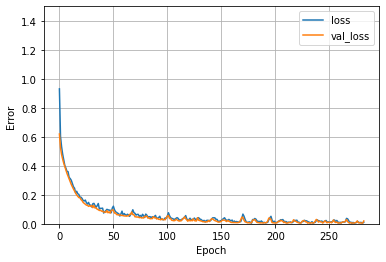

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Evaluate neural network

In [ ]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

3/3 [==============================] - 0s 3ms/step - loss: 0.0195 - mse: 0.0195
loss test data:  0.019503828138113022
mse test data:  0.019503828138113022
3/3 [==============================] - 0s 2ms/step - loss: 0.0166 - mse: 0.0166
loss train data:  0.016552643850445747
mse train data:  0.016552643850445747


Plot results

<function matplotlib.pyplot.show>

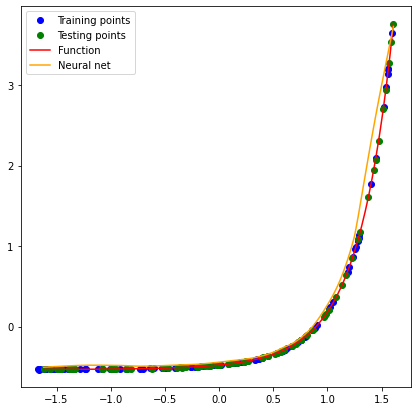

In [ ]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show